# Networks

# Libraries

In [1]:
import pandas as pd
import re
from tqdm import tqdm
import numpy as np
# networks
import networkx as nx
#import igraph as ig
# plotting
import matplotlib.pyplot as plt
# plotly
import plotly.graph_objects as go
# ig
import igraph as ig

# Data

In [2]:
C = pd.read_pickle("../output/C_for_NLP.pkl")
nmf_df = pd.read_pickle("../output/nmf_df.pkl")

In [3]:
C = pd.merge(C, nmf_df[["topic", "value", "header_id"]], on='header_id')

In [4]:
C.head()

,book,header_id,book_page_start,book_page_end,header_eintrag,eintrag_text,eintrag_ids,eintrag_text_clean,header_eintrag_clean,guess,topic,value
0,C1_MDZ,C1_facs_1_region_1699100518519_15,3,4,A,enn man eine große Stadt von\nder Ferne bescha...,"[facs_1_region_1700252961470_35, facs_1_region...","enn große Stadt Ferne beschaut, lehren Wolken ...",A,None,6.0,0.093936
1,C1_MDZ,C1_facs_2_region_1699101628768_50,4,4,AWOhäufer.,Es gereicht dem gesunden Sinne der Be=\nwohner...,"[facs_2_region_1699458370242_69, facs_2_region...","gereicht gesunden Sinne Bewohner Wiens Ehre, d...",AWOhäufer,None,1.0,0.091607
2,C1_MDZ,C1_facs_2_region_1699101668887_62,4,5,Abaens.,"Der Abacus ist ein Bret oder Tisch, worauf\nvo...","[facs_2_region_1699458442872_88, facs_3_region...","Abacus Bret Tisch, worauf vormals, Kopfrechner...",Abaens,None,6.0,0.053619
3,C1_MDZ,C1_facs_3_region_1699102206352_41,5,7,Abensperg= und Traunische (Gräf=\nlich=) Fidei...,Diese in der Herrngasse liegenden\nHäuser (240...,"[facs_3_region_1699458534980_119, facs_3_regio...",Herrngasse liegenden Häuser (240 241) gehören ...,Abensperg= und Traunische Fideicommißhäuser,Gebäude,6.0,0.106255
4,C1_MDZ,C1_facs_5_region_1699102766670_47,7,8,Abgebrannte Haus (Das,in der Vorstadt Wieden (447) ist ein ar=\nchit...,"[facs_5_region_1699458780055_191, facs_5_regio...",Vorstadt Wieden (447) architektonisches Monstr...,Abgebrannte Haus,Gebäude,8.0,0.123893


# Co-occurence list

In [5]:
# find all headers in  other texts, which appear as distinc words
C["occures_in"] = None
for i, row in tqdm(C.iterrows(), total=len(C)):
    occures_in = []
    for j, row2 in C.iterrows():
        #as distinct words
        if row["header_eintrag_clean"] in row2["eintrag_text"].split(" ") and i != j:
            occures_in.append(row2["header_id"])
    C.at[i, "occures_in"] = occures_in

  0%|          | 0/1294 [00:00<?, ?it/s]

100%|██████████| 1294/1294 [03:55<00:00,  5.50it/s]


# Adjacency list

In [6]:
adjacency_list = []
for i, row in tqdm(C.iterrows(), total=len(C)):
    for occ in row["occures_in"]:
        adjacency_list.append([row["header_id"], occ])
adjacency_list = pd.DataFrame(adjacency_list, columns=["header_id", "occures_in"])

100%|██████████| 1294/1294 [00:00<00:00, 9803.25it/s]


In [8]:
adjacency_list.to_csv("../output/adjacency_list.csv", index=False)

# Network

In [9]:
G = nx.from_pandas_edgelist(adjacency_list, "header_id", "occures_in", create_using=nx.DiGraph())

# remove self loops
self_loops = list(nx.selfloop_edges(G))
G.remove_edges_from(self_loops)

# remove nodes with no edges
no_edges = [node for node, degree in dict(G.degree()).items() if degree == 0]
G.remove_nodes_from(no_edges)

In [10]:
# update node info from C

for i, row in tqdm(C.iterrows(), total=len(C)):
    if row["header_id"] in G.nodes:
        G.nodes[row["header_id"]]["header_eintrag"] = row["header_eintrag"]
        G.nodes[row["header_id"]]["topic"] = row["topic"]
        G.nodes[row["header_id"]]["topic_value"] = row["value"]

100%|██████████| 1294/1294 [00:00<00:00, 10027.73it/s]


In [10]:
#export to gephi
nx.write_gexf(G, "../output/G.gexf")

In [11]:
# change to G to undirected
# no idea, why it was directed in the first place,
# maybe because of adj list, idk
G_dir = G
G = G.to_undirected()

In [12]:
def plot_node_w_nbs(eintrag_name, display_names = False):
    # get node
    node = [node for node, attr in G.nodes(data=True) if attr["header_eintrag"] == eintrag_name][0]

    # get neighbors
    neighbors = list(G.neighbors(node))
    # get subgraph
    subgraph = G.subgraph(neighbors + [node])
    # plot
    pos = nx.circular_layout(subgraph)
    # position the main node in the center
    pos[node] = np.array([0, 0])
    # add more space between the neighbords
    for i, nb in enumerate(neighbors):
        pos[nb] = np.array([np.cos(2*np.pi*i/len(neighbors)), np.sin(2*np.pi*i/len(neighbors))])
    #draw main node as red and label by attr "header_eintrag"
    nx.draw_networkx_nodes(subgraph, pos, nodelist=[node], node_color="red", node_size=1500)
    # draw neighbors as blue and label by attr "header_eintrag"
    nx.draw_networkx_nodes(subgraph, pos, nodelist=neighbors, node_color="blue", node_size=500)
    # draw edges
    nx.draw_networkx_edges(subgraph, pos, width=1.0, alpha=0.5)

    node_labels = {n: G.nodes[n]["header_eintrag"] for n in subgraph.nodes()}
    label_pos = {k: (v[0], v[1]+0.15) for k, v in pos.items()} 
    label_pos[node] = np.array([0, 0])
    nx.draw_networkx_labels(subgraph, label_pos, labels=node_labels, font_size=7)
    # add margin
    plt.margins(0.2)
    plt.show()
    
    # display names
    if display_names:
        print("Main node: ", eintrag_name)
        # per 15 per line
        print("Neighbors:")
        print("\n\t".join([G.nodes[n]["header_eintrag"] for n in neighbors]))

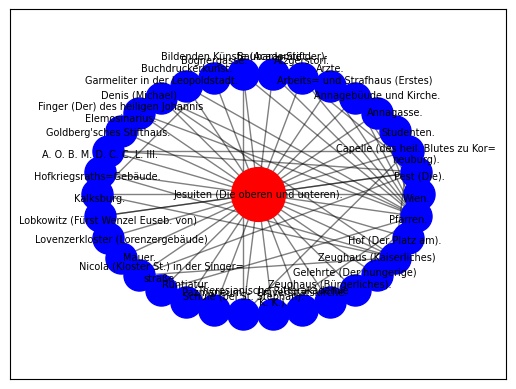

Main node:  Jesuiten (Die oberen und unteren).
Neighbors:
Pest (Die).
	Capelle (des heil. Blutes zu Kor=
neuburg).
	Studenten.
	Annagasse.
	Annagebüude und Kirche.
	Arbeits= und Strafhaus (Erstes)
	Arzte.
	Atzgerstorf.
	Baubara=Stift.
	Bildenden Künste (Academie der)
	Bognergasse.
	Buchdruckerkunst.
	Garmeliter in der Leopoldstadt.
	Denis (Michael)
	Finger (Der) des heiligen Johannis
Elemosinarius.
	Goldberg'sches Stifthaus.
	A. O. B. M. D. C. C. L. III.
	Hofkriegsraths=Gebäude.
	Kalksburg.
	Lobkowitz (Fürst Wenzel Euseb. von)
	Lovenzerkloster (Lorenzergebäude)
	Mauer.
	Nicola (Kloster St.) in der Singer=
straße.
	Runtiatur.
	Pazmaneum.
	Schule (bei St. Stephan).
	Theresianische Ritterakademie
K. K.).
	Universitätskirche.
	Zeughaus (Bürgerliches).
	Gelehrte (Der hungerige)
	Zeughaus (Kaiserliches)
	Hof (Der Platz am).
	Pfarren.
	Wien.


In [13]:
plot_node_w_nbs("Jesuiten (Die oberen und unteren).", display_names=True)

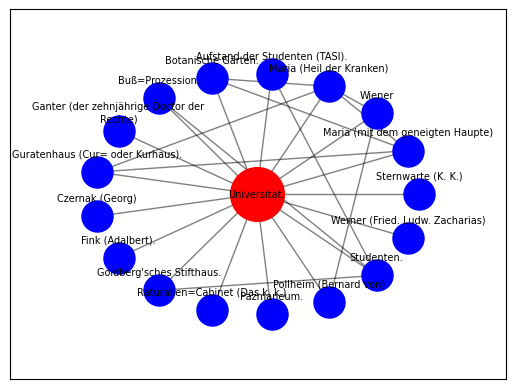

Main node:  Universität.
Neighbors:
Sternwarte (K. K.)
	Maria (mit dem geneigten Haupte)
	Wiener
	Maria (Heil der Kranken)
	Aufstand der Studenten (TASI).
	Botanische Gärten.
	Buß=Prozession.
	Ganter (der zehnjährige Doctor der
Rechte)
	Guratenhaus (Cur= oder Kurhaus).
	Czernak (Georg)
	Fink (Adalbert).
	Goldberg'sches Stifthaus.
	Raturalien=Cabinet (Das k. k.)
	Pazmaneum.
	Pollheim (Bernard von)
	Studenten.
	Werner (Fried. Ludw. Zacharias)


In [14]:
plot_node_w_nbs("Universität.", display_names=True)

# Community detection

In [ ]:
"""https://networkx.org/documentation/stable/auto_examples/algorithms/plot_betweenness_centrality.html#sphx-glr-auto-examples-algorithms-plot-betweenness-centrality-py"""

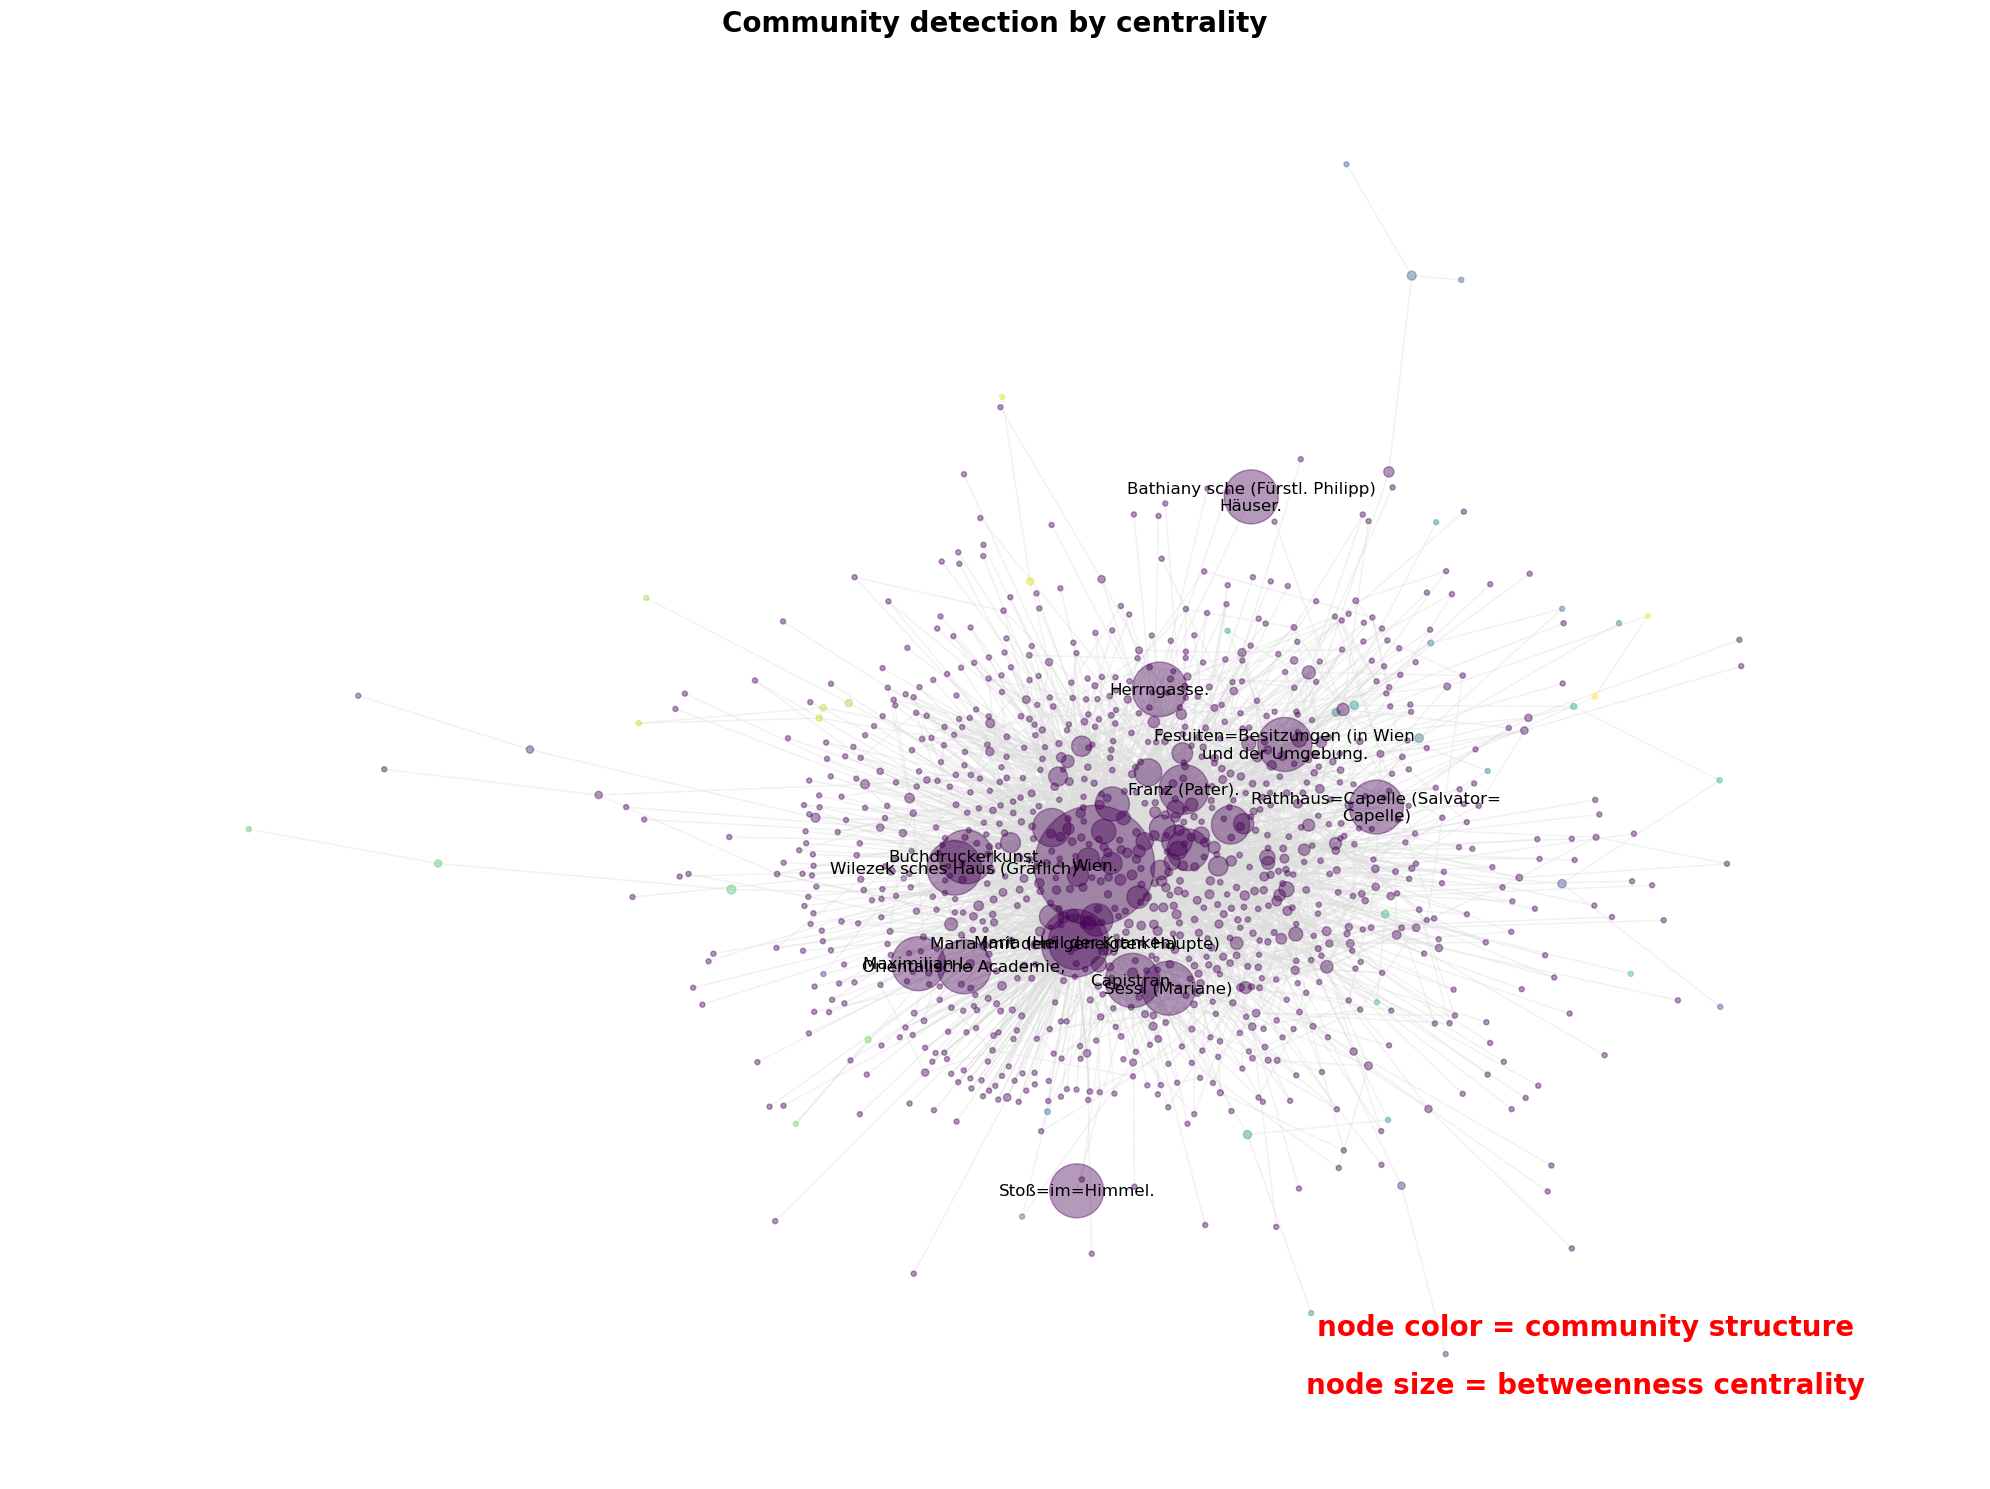

In [11]:
components = nx.connected_components(G)
largest_component = max(components, key=len)
H = G.subgraph(largest_component)

# compute centrality
centrality = nx.betweenness_centrality(H, k=10, endpoints=True)

# compute community structure
lpc = nx.community.label_propagation_communities(H)
community_index = {n: i for i, com in enumerate(lpc) for n in com}

#### draw graph ####
fig, ax = plt.subplots(figsize=(20, 15))
pos = nx.spring_layout(H, k=0.1, seed=4572321)
node_color = [community_index[n] for n in H]
node_size = [v * 15000 for v in centrality.values()]
nx.draw_networkx(
    H,
    pos=pos,
    with_labels=False,
    node_color=node_color,
    node_size=node_size,
    edge_color="gainsboro",
    alpha=0.4,
)

# label the top x nodes with the highest centrality
centrality_rank = sorted(centrality, key=centrality.get, reverse=True)
x = 15
topx = centrality_rank[:x]
labels = {n: H.nodes[n]["header_eintrag"] for n in topx}

# draw labels and save plot
nx.draw_networkx_labels(H, pos=pos, labels=labels, font_size=12)

# Title/legend
font = {"color": "k", "fontweight": "bold", "fontsize": 20}
ax.set_title("Community detection by centrality", font)
# Change font color for legend
font["color"] = "r"

ax.text(
    0.80,
    0.10,
    "node color = community structure",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)
ax.text(
    0.80,
    0.06,
    "node size = betweenness centrality",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

# Resize figure for label readability
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()

# Louvain

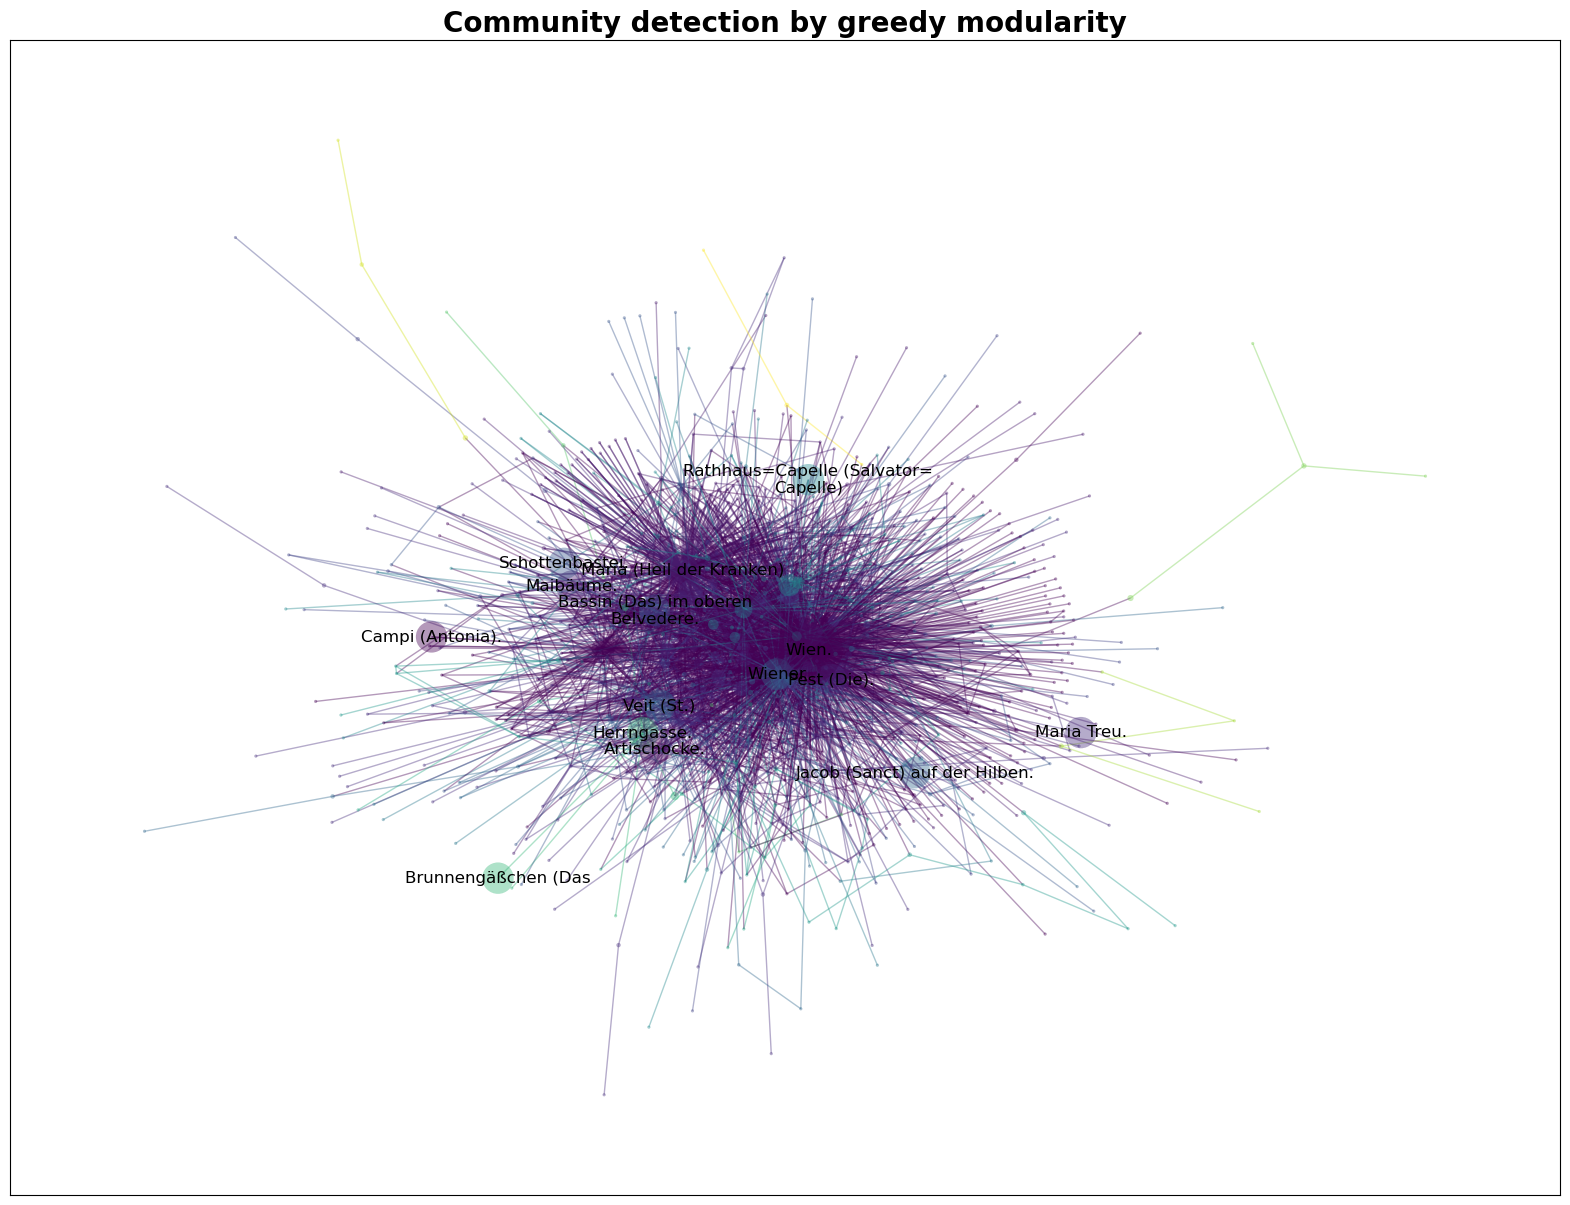

In [59]:
# louvain
louvain = nx.community.greedy_modularity_communities(H)
community_index = {n: i for i, com in enumerate(louvain) for n in com}

#### draw graph ####
fig, ax = plt.subplots(figsize=(20, 15))
pos = nx.spring_layout(H, k=0.1)
#pos = nx.kamada_kawai_layout(H, scale=2)
node_color = [community_index[n] for n in H]
node_size = [v * 5000 for v in centrality.values()]
#edge colour by community
edge_color = []
for e in H.edges:
    if community_index[e[0]] == community_index[e[1]]:
        edge_color.append(community_index[e[0]])
    else:
        edge_color.append(0)

nx.draw_networkx(
    H,
    pos=pos,
    with_labels=False,
    node_color=node_color,
    node_size=node_size,
    edge_color= edge_color,
    alpha=0.4,
    linewidths=0.1,
)

# label the top x nodes with the highest centrality
centrality_rank = sorted(centrality, key=centrality.get, reverse=True)
x = 15
topx = centrality_rank[:x]
labels = {n: H.nodes[n]["header_eintrag"] for n in topx}

# draw labels and save plot
nx.draw_networkx_labels(H, pos=pos, labels=labels, font_size=12)

# Title/legend
font = {"color": "k", "fontweight": "bold", "fontsize": 20}
ax.set_title("Community detection by greedy modularity", font)
# Change font color for legend
plt.show()

spring_layout
spectral_layout
kamada_kawai_layout
shell_layout
circular_layout
spring_layout
random_layout


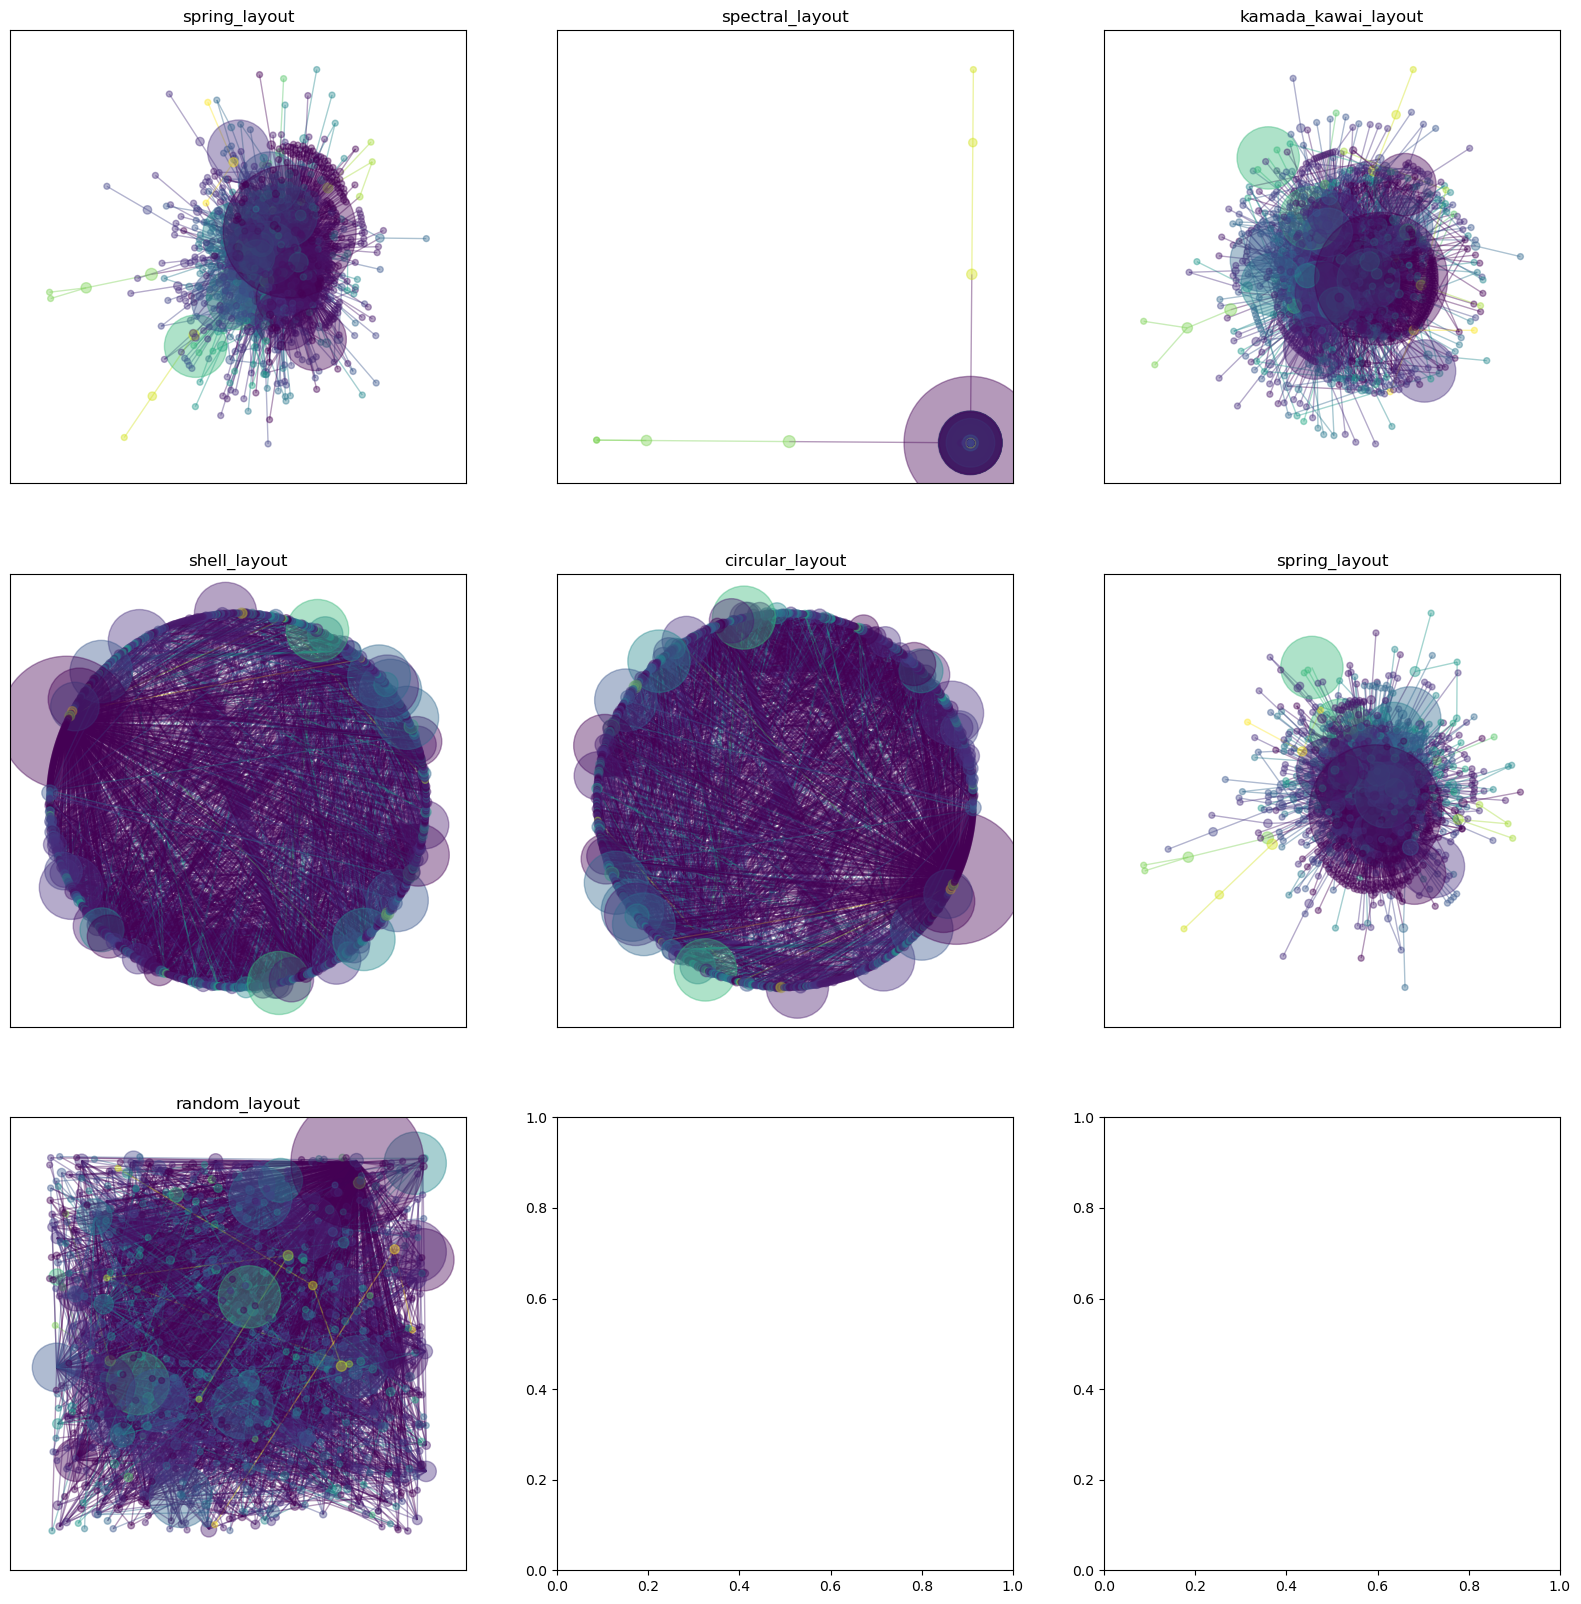

In [49]:
# plot different layouts
layouts = [
    nx.spring_layout,
    nx.spectral_layout,
    nx.kamada_kawai_layout,
    nx.shell_layout,
    nx.circular_layout,
    nx.fruchterman_reingold_layout,
    nx.random_layout,
]

fig, axes = plt.subplots(3, 3, figsize=(20, 20))
axes = axes.flatten()

for i, layout in enumerate(layouts):
    print(layout.__name__)
    ax = axes[i]
    pos = layout(H)
    nx.draw_networkx(
        H,
        pos=pos,
        with_labels=False,
        node_color=node_color,
        node_size=node_size,
        edge_color=edge_color,
        alpha=0.4,
        ax=ax,
    )

    ax.set_title(layout.__name__)

#plt.tight_layout()

plt.show()